# Intro to decision trees

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
from graphviz import Digraph

<font color = 'green'> __Nonparametric model__: <font color = 'red'> **A model where the parameters (number, meaning) are not fixed before training. For example, in a curve fit, we specify the model function, coefficients, and what the coefficients mean before doing anything else. In a nonparametric model, we don't know the full structure of the model in advance.**
    
**This can offer a lot of flexibility, but can also increase the variance of our models and the risk of overfitting.**

<font color = 'green'> __Entropy:__ <font color = 'red'> **A measure of uncertainty applied to a probability distribution. Calculated using the formula**

<font color = 'black'>
$$ H(X) = -\sum_i p_i \log_2(p_i) $$

<font color = 'red'>
    
**where $p_i$ are the probabilities of the outcomes/values $x_i$ of $X$. It's named for an analogous concept in statistical physics/thermodynamics, which measures the disorder in a collection of particles using a similar mathematical function. Originated in the theory of communication and message encoding developed by Claude Shannon and others (which is why you sometimes hear this called Shannon entropy) at Bell Labs in the 1940s and later.**

<font color = 'green'> __Conditional entropy:__ <font color = 'red'> **Like probabilities, we can update the calculation of entropy when we observe a related variable. If the observed variable is categorical, we can think of it as breaking the data into subsets. We calculate the entropy of the target variable within each subset normally, then take a weighted average according to the frequency of each subset.**
    
<font color = 'black'> 
$$ H(X | Y) = \sum_j P(\mbox{subset j}) H(\mbox{subset j}) $$

<font color = 'red'>     
**or, more formally (this is what you'll probably see if you look the definition up):**

<font color = 'black'> 
$$ H(X | Y) = \sum_j P(Y = y_j) H(X | Y = y_j) $$

<font color = 'green'> __Mutual information:__ <font color = 'red'> **If $X$ and $Y$ are two variables, the mutual information is**
    
<font color = 'black'>
$$I(X; Y) = H(X) - H(X | Y)$$
    
<font color = 'red'> 
    
**or the "gap" between the entropy of a variable, and the conditional entropy after observing a related variable. Since it measures how much uncertainty is reduced by the observation, this is also sometimes called "information gain." Note $I(X; Y) = I(Y; X)$ even though $H(X | Y) \neq H(Y | X)$.**

<font color = 'green'> __Cost function / benefit function:__ <font color = 'red'> **A cost function (also called a loss function) is a measure of goodness of fit that we want to minimize -- i.e. something that measures the error in our model. Example: sum of squared residuals in curve fitting. A benefit function is the opposite: a measure of goodness of fit that we try to maximize. Here, mutual information is serving as a benefit function.**
    
**Note you can generally translate between cost / benefit functions by multiplying by -1; this is sometimes done for computational or mathematical convenience.**

In [2]:
# Utility function for estimating the entropy of a target variable from a data frame.

def entropy(df, target):
    '''
    Computes the entropy of the target variable in the data frame.
    Parameters:
        df: a DataFrame containing labeled data with a categorical target variable
        target: the name of the target variable (str)
    Returns:
        H, the entropy of the target variable (float)
    '''
    labels = {label for label in df[target]}
    probs = [len(df[df[target] == label]) / len(df) for label in labels]
    return -sum(p * np.log2(p) for p in probs if p != 0)

# Utility function for estimating conditional entropy from a data frame.

def cond_entropy(df, pred, target):
    '''
    Computes the conditional entropy of a target variable given a certain predictor.
    Parameters:
        df: a DataFrame containing labeled data with categorical predictors and a categorical target
        pred: the name of the attribute being used as a predictor (str)
        target: the name of the target variable (str)
    Returns:
        H, the conditional entropy (float)
    '''
    # These are set comprehensions. Like list comprehensions but they make sets.
    # We use sets so that there are no duplicates; we want to consider each category/label only once
    categories = {cat for cat in df[pred]}
    labels = {label for label in df[target]}
    # Make a list of subsets of the data frame, broken down by the predictor
    subsets = [df[df[pred] == cat] for cat in categories]
    H = 0
    for subset in subsets:
        if len(subset) > 0: # avoid some errors
            # Calculate the label probabilities within the subset, put them in a list
            probs = [len(subset[subset[target] == label]) / len(subset) for label in labels]
            # Calculate the contribution of this subset to the conditional entropy and add it to H
            H += (len(subset) / len(df)) * (-sum(p * np.log2(p) for p in probs if p != 0))
    return H

In [3]:
# Data from the 60s on survival after surgery for breast cancer
surv = pd.read_csv('survival.csv')
surv

,Age,Year,Nodes,Survival
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1
...,...,...,...,...
301,75,62,1,1
302,76,67,0,1
303,77,65,3,1
304,78,65,1,2


In this data frame, a `Survival` value of 1 indicates survival 5+ years, 2 indicates death within 5 years.

In [4]:
entropy(surv, 'Survival')

0.833764907210665

## Finding the best variable to split on

We want to formulate a decision tree as a sequence of yes/no questions about the predictors. If the predictors are categorical, especially binary categorical, it is simple to formulate the questions.

All of our predictors in this data set are numerical, though. So our questions should look like:
* is age > 35?
* is nodes = 0?
* etc.

At each step we split the data into two pieces, and eventually make an estimate based on that.

There are many such questions we can ask at any point. How do we pick one? Look for the best mutual information/information gain.

#### Exercise

Write a function called `mutual_information` that takes a data frame, a predictor variable, a cutoff value for that predictor variable, and a target variable. The function returns the mutual information of the target variable and the binary categorical variable `predictor > / <= cutoff`.

**Hint:** create a temporary copy of the data frame, expand it by adding a new column representing the binary categorical variable, then use the utility functions `entropy` and `conditional_entropy` defined above.

In [5]:
def mutual_information(df, predictor, cutoff, target):
    temp_df = df.copy()
    temp_series = pd.Series(df[predictor] > cutoff)
    temp_df['new_pred'] = temp_series
    inf = entropy(df, target) - cond_entropy(temp_df, 'new_pred', target)
    return inf

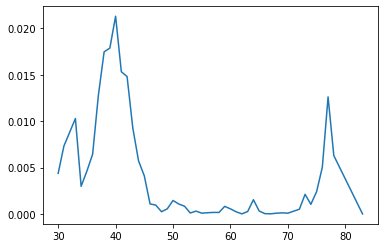

In [6]:
plt.plot(sorted(set(surv['Age'])), 
         [mutual_information(surv, 'Age', x, 'Survival') for x in sorted(set(surv['Age']))])

This plot tells us that if we ask about age, the question should be "is `age > 40`?"

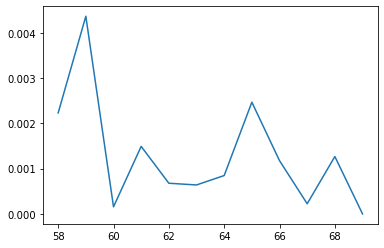

In [7]:
plt.plot(sorted(set(surv['Year'])), 
         [mutual_information(surv, 'Year', x, 'Survival') for x in sorted(set(surv['Year']))])

So the year has very little mutual information with the survival rate.

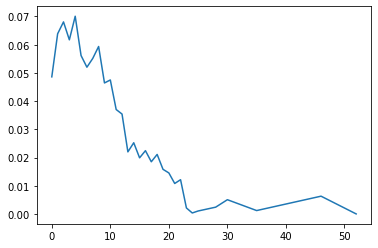

In [8]:
plt.plot(sorted(set(surv['Nodes'])), 
         [mutual_information(surv, 'Nodes', x, 'Survival') for x in sorted(set(surv['Nodes']))])

Now we can settle on something: the best first question to ask is: is `nodes > 4`? In fact, a 1983 study [https://www.ncbi.nlm.nih.gov/pubmed/6352003] groups patients into 0 nodes, 1-3 nodes, and 4+ nodes, so our approach suggests a grouping pretty similar to that, which is encouraging.

Let's see what the survival rates are in these two subgroups.

In [9]:
surv_a = surv[surv['Nodes'] <= 4]
surv_b = surv[surv['Nodes'] > 4]

In [10]:
sum(surv_a['Survival'] == 1) / len(surv_a)

0.8173913043478261

In [11]:
sum(surv_b['Survival'] == 1) / len(surv_b)

0.4868421052631579

#### Exercise

Apply the same approach as above to split each of the data frames `surv_a` and `surv_b` into two.

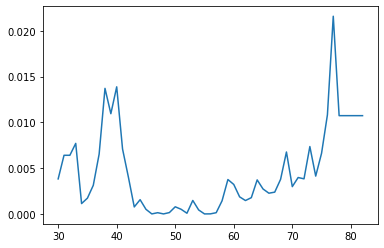

In [12]:
plt.plot(np.arange(30, 83), [mutual_information(surv_a, 'Age', x, 'Survival') for x in np.arange(30, 83)])

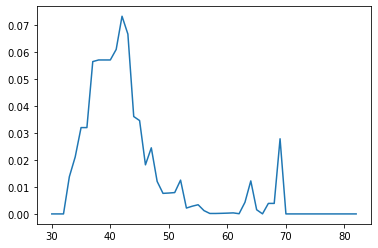

In [13]:
plt.plot(np.arange(30, 83), [mutual_information(surv_b, 'Age', x, 'Survival') for x in np.arange(30, 83)])

Now let's make our estimates.

In [14]:
surv_a1 = surv_a[surv_a['Age'] <= 76]
surv_a2 = surv_a[surv_a['Age'] > 76]
surv_b1 = surv_b[surv_b['Age'] <= 43]
surv_b2 = surv_b[surv_b['Age'] > 43]
print(sum(surv_a1['Survival'] == 1) / len(surv_a1)) # <= 4 nodes, age <= 40
print(sum(surv_a2['Survival'] == 1) / len(surv_a2)) # <= 4 nodes, age > 40
print(sum(surv_b1['Survival'] == 1) / len(surv_b1)) # > 4 nodes, age <= 43
print(sum(surv_b2['Survival'] == 1) / len(surv_b2)) # > 4 nodes, age > 43

0.8237885462555066
0.3333333333333333
0.7647058823529411
0.4067796610169492


## Visualizing the tree

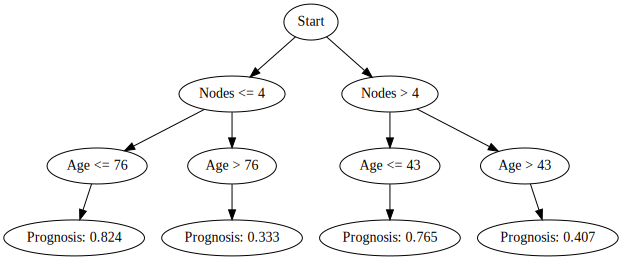

In [15]:
# Uncomment this if you have graphviz working

tree = Digraph()
tree.node('top', 'Start')
tree.node('A', 'Nodes <= 4')
tree.node('B', 'Nodes > 4')
tree.node('AA', 'Age <= 76')
tree.node('AB', 'Age > 76')
tree.node('BA', 'Age <= 43')
tree.node('BB', 'Age > 43')

tree.node('end_AA', 'Prognosis: 0.824')
tree.node('end_AB', 'Prognosis: 0.333')
tree.node('end_BA', 'Prognosis: 0.765')
tree.node('end_BB', 'Prognosis: 0.407')

tree.edge('top', 'A')
tree.edge('top', 'B')
tree.edge('A', 'AA')
tree.edge('A', 'AB')
tree.edge('B', 'BA')
tree.edge('B', 'BB')

tree.edge('AA', 'end_AA')
tree.edge('AB', 'end_AB')
tree.edge('BA', 'end_BA')
tree.edge('BB', 'end_BB')

tree


## A conceptual digression

From a more theoretical perspective, what a tree does is:
* partition the space of predictors into subsets
* fit a very simple model (a constant) on each subset

Let's visualize the prognosis as a function of age and nodes:

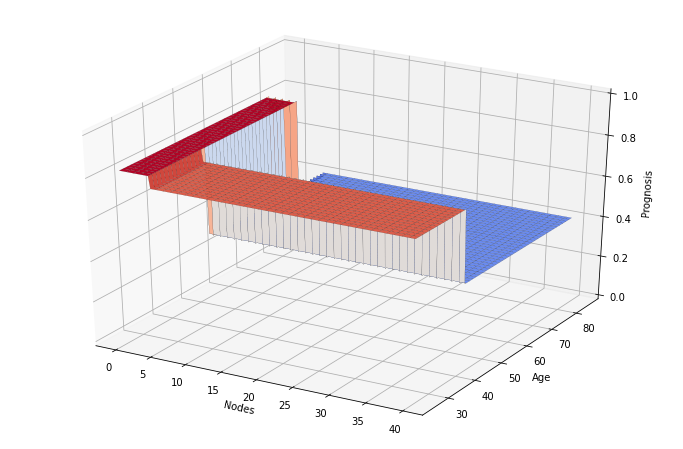

In [16]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')

# Make data
Y = np.arange(25, 85, 0.25)
X = np.arange(0, 40, 0.25)
X, Y = np.meshgrid(X, Y)

# Quick and dirty prediction function
def predict(nodes, age):
    if nodes <= 4:
        if age <= 76:
            return 0.824
        else:
            return 0.333
    else:
        if age <= 43:
            return 0.765
        else:
            return 0.407

Z = np.array([predict(x, y) for [x,y] in np.c_[X.ravel(), Y.ravel()]])
Z = Z.reshape(Y.shape)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0.1, edgecolor = 'black', antialiased=True)

ax.set_xlabel('Nodes')
ax.set_ylabel('Age')
ax.set_zlabel('Prognosis')
# Customize the z axis.
ax.set_zlim(0, 1)

plt.show()

Notice the shape of the flat regions. Because of the way we structure our tree, these areas are always rectangles -- i.e., decision boundaries are always parallel to a coordinate axis. This is a limitation of these trees. In theory, any shape of decision boundary could be approximated by these rectangles, but that would mean a very complex tree and a high risk of overfitting.

## Ok, but how good is this really?

We committed a sin by using our entire data set to build the model instead of holding out some data for validation. Next time, we repent our crimes. We'll discover some of the weaknesses of decision trees and how they may be fixed in practice.

In [ ]:
# Randomly select a small amount of data to hold out

train_idx = np.random.choice(surv.index, 256, replace = False)
train = surv.loc[train_idx]
test = surv.drop(train_idx)
train_X = train.drop('Survival', axis=1)
train_y = train['Survival']
test_X = test.drop('Survival', axis=1)
test_y = test['Survival']

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (15, 4))
for i in range(3):
    train_idx = np.random.choice(surv.index, 256, replace = False)
    train = surv.loc[train_idx]
    axs[i].plot(np.arange(30, 84), 
         [mutual_information(train, 'Age', x, 'Survival') for x in np.arange(30, 84)])
    #axs[i].plot(sorted(set(train['Age'])), 
    #     [mutual_information(train, 'Age', x, 'Survival') for x in sorted(set(train['Age']))])

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (15, 4))
for i in range(3):
    train_idx = np.random.choice(surv.index, 256, replace = False)
    train = surv.loc[train_idx]
    axs[i].plot(np.arange(0, 55), 
         [mutual_information(train, 'Nodes', x, 'Survival') for x in np.arange(0, 55)])
    #axs[i].plot(sorted(set(train['Age'])), 
    #     [mutual_information(train, 'Age', x, 'Survival') for x in sorted(set(train['Age']))])

<font color = 'green'> __Greedy algorithm:__ <font color = 'black'> The decision tree algorithm we described above is a *greedy algorithm*, meaning at each step it takes the best step. This doesn't always mean finding the best possible tree overall, because the outcome of our early decisions limits our later ones. Why use the greedy approach? It's much faster -- the problem of finding the optimal binary tree is NP-complete (very computationally expensive).

<font color = 'green'> __Sources of prediction error:__ <font color = 'black'> Broadly speaking, prediction error can be broken down into three types:
* irreducible error: this comes from natural randomness in the target variable. We can't do anything about this.
* bias: systematic error in our predictions. Generally comes from a model that isn't able to capture all of the features in the data. Think using a linear function to fit quadratic data -- the model assumptions don't match the true relationships.
* variance: random error coming from sensitivity to differences in the training data. If the model is sensitive to small changes in the training set, it will tend to fit itself to random noise, which can lead to worse predictions. In other words, high variance models are prone to overfitting the training data.

<font color = 'green'> __Model complexity:__ <font color = 'black'> Models with a lot of parameters (complex models) tend to have lower bias, because they have more flexibility to learn features of the training data. Models with few parameters (simple models) tend to have lower variance (for the same reason).

<font color = 'green'> __Bias-variance tradeoff:__ <font color = 'black'> It's a common (not universal) phenomenon in supervised learning that changing model parameters will simultaneously increase bias and reduce variance or vice versa. So the changes we make will make one source of error better and the other worse.
    
Often models that have naturally high variance can be improved by limiting the model complexity, adding a small amount of bias but controlling the variance. Techniques to do this are called "regularization" techniques.

<font color = 'green'> __Trees need regularization, badly:__ <font color = 'black'> The number of parameters in a decision tree is the number of splits. We stopped splitting after three splits above because we were doing it by hand, but a computer using the greedy algorithm will happily keep splitting the data set until every leaf of the tree is "pure" (only one target class). If we don't restrict this in some way, we will end up with really bad overfitting.

<font color = 'green'> __Pruning__: <font color = 'black'> Regularization for trees that works by fitting a tree without restrictions, then going back and removing leaves/splits that don't help much. `sklearn` doesn't implement this, so we won't go into detail.

In [ ]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz 
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import confusion_matrix

In [ ]:
cls = DecisionTreeClassifier(max_depth = 2)
cls.fit(train_X, train_y)

In [ ]:
from graphviz import Source
Source(export_graphviz(cls, out_file=None, feature_names=train_X.columns))

<font color = 'green'> __Gini impurity:__ <font color = 'black'> The sklearn algorithm (CART -- classification and regression trees) by default uses a different objective function than we did:

$$\mathrm{gini} = 1 - \sum_{i} p_i^2$$

where
    
$$ p_i = \frac{|\mbox{instances of class $i$}|}{|\mbox{all instances}|} $$
    
This is 0 when all the instances in a subset are the same class. sklearn tries to find the splitting with the lowest (weighted) average Gini impurity across the classes.
    
An alternative calculation calculates $p_i$ as

$$ p_i = \frac{|\mbox{instances of class $i$}| + 1}{|\mbox{all instances}| + 2} $$
    
This is a regularization technique based on pseudocounts (just like we used in naive Bayes).

In [ ]:
np.average(cross_val_score(cls, train_X, train_y, cv = 5))

In [ ]:
averages = np.zeros(15)
errors = np.zeros(15)
for m in range(1, 16):
    cls = DecisionTreeClassifier(max_depth = m)
    scores = cross_val_score(cls, train_X, train_y, cv = 5)
    averages[m - 1] = np.average(scores)
    errors[m - 1] = np.std(scores) / np.sqrt(5)

plt.figure(figsize=(8,8))
plt.errorbar(np.arange(1, 16), averages, marker = 'o', yerr = errors, color = 'black', capsize = 5)
plt.xlabel('Maximum tree depth')
plt.ylabel('Accuracy score from 5-fold CV ($\pm$ std. error)')
plt.xticks = np.arange(1, 16)
    

<font color = 'green'> __Ensemble models:__ <font color = 'black'> An ensemble models trains a bunch of similar models, with some randomness so that they are somewhat different. At prediction time, let all your models vote on the prediction.
* hard voting: each model predicts a class, take the most-predicted class
* soft voting: each model predicts class probabilities, average the probabilities

Ensemble models can be really powerful -- even if an individual model's performance is only a little better than random guessing, the ensemble can be accurate, as long as (a) you have enough models in your ensemble, and (b) they are all sufficiently different -- a thousand near-identical trees won't do any better than one tree.

<font color = 'green'> __Bagging:__ <font color = 'black'> Creating an ensemble by using the same type of model and hyperparameters, but training them all on different, randomly chosen subsets of the training data. Generally this random sampling from the training data is done **with** replacement (called bootstrapping) to increase the "effective size" of our training data. Bagging works really well with low-bias but high-variance models, like trees.

<font color = 'green'> __Random forest:__ <font color = 'black'> Simple bagging works well on trees but has one potential weakness: the trees can to be too similar to one another. This limits the benefit of the averaging. Random forests attempt to de-correlate the individual trees by choosing predictors at random. Specifically, before every split, we choose a random subset of the available predictors to analyze for splitting.

In [ ]:
cls = RandomForestClassifier(n_estimators = 500, oob_score = True)
cls.fit(train_X, train_y)

In [ ]:
cls.oob_score_

<font color = 'green'> __Out-of-bag evaluation__: <font color = 'black'> An alternative to cross-validation. When we draw a bootstrap sample with replacement, if we draw $n$ instances from a set of the same size $n$, on average about 63% of the instances will end up being drawn. That leaves some instances that don't get used for training, so they can be used for validation instead. Here we go through the training set, and predict for each $x_i$ using only the trees in the forest that didn't see $x_i$ in training, and use the accuracy rate for validation.

In [ ]:
scores = np.zeros(15)
for m in range(1, 16):
    cls = RandomForestClassifier(n_estimators = 500, max_depth = m, oob_score = True)
    cls.fit(train_X, train_y)
    scores[m-1] = cls.oob_score_

plt.figure(figsize=(8,8))
plt.plot(np.arange(1, 16), scores, 'o', color = 'black')
plt.xlabel('Maximum tree depth')
plt.ylabel('Accuracy score from OOB ($\pm$ std. error)')
plt.xticks = np.arange(1, 16)

In [ ]:
cls_tree = DecisionTreeClassifier(max_depth = 4)
cls_forest = RandomForestClassifier(n_estimators = 500, max_depth = 4)
cls_tree.fit(train_X, train_y)
cls_forest.fit(train_X, train_y)

preds_tree = cls_tree.predict(test_X)
preds_forest = cls_forest.predict(test_X)

print("Confusion matrix for tree:")
print(confusion_matrix(preds_tree, test_y))
print("\nConfusion matrix for forest:")
print(confusion_matrix(preds_forest, test_y))